<a href="https://colab.research.google.com/github/anubhav100rao/Anubhav_python_dev/blob/main/Deepfake_TSIPN_Journal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparing script for feature extraction from LA classification and deepfake evaluation data**

In [ ]:
! unzip /content/drive/MyDrive/DeepFake/LA.zip

Streaming output truncated to the last 5000 lines.
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7787040.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_2924301.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9249366.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_3442936.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7772915.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_5569336.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7773607.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7813281.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9705954.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_2427464.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1000273.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_5263550.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1642109.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1339848.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9495857.flac  
  inflating: LA/ASV

In [ ]:
!unzip /content/drive/MyDrive/DeepFake/ASVspoof2021_DF_eval_part00.tar.gz

Archive:  /content/drive/MyDrive/DeepFake/ASVspoof2021_DF_eval_part00.tar.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/DeepFake/ASVspoof2021_DF_eval_part00.tar.gz or
        /content/drive/MyDrive/DeepFake/ASVspoof2021_DF_eval_part00.tar.gz.zip, and cannot find /content/drive/MyDrive/DeepFake/ASVspoof2021_DF_eval_part00.tar.gz.ZIP, period.


In [ ]:
train_df = pd.read_csv('/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt', sep = ' ', header = None, usecols = [1,4], names = ['filename', 'class'])
train_df

,filename,class
0,LA_T_1138215,bonafide
1,LA_T_1271820,bonafide
2,LA_T_1272637,bonafide
3,LA_T_1276960,bonafide
4,LA_T_1341447,bonafide
...,...,...
25375,LA_T_9717580,spoof
25376,LA_T_9779814,spoof
25377,LA_T_9783312,spoof
25378,LA_T_9839348,spoof


In [ ]:
dev_df = pd.read_csv('/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt', sep = ' ', header = None, usecols = [1,4], names = ['filename', 'class'])
dev_df

,filename,class
0,LA_D_1047731,bonafide
1,LA_D_1105538,bonafide
2,LA_D_1125976,bonafide
3,LA_D_1293230,bonafide
4,LA_D_1340209,bonafide
...,...,...
24839,LA_D_9924204,spoof
24840,LA_D_9931163,spoof
24841,LA_D_9935163,spoof
24842,LA_D_9944718,spoof


In [ ]:
eval_df = pd.read_csv('/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep = ' ', header = None, usecols = [1,4], names = ['filename', 'class'])
eval_df

,filename,class
0,LA_E_2834763,spoof
1,LA_E_8877452,spoof
2,LA_E_6828287,spoof
3,LA_E_6977360,spoof
4,LA_E_5932896,spoof
...,...,...
71232,LA_E_1665632,bonafide
71233,LA_E_5085671,spoof
71234,LA_E_4926022,spoof
71235,LA_E_2894498,bonafide


In [ ]:
train_df['class'].value_counts()

spoof       22800
bonafide     2580
Name: class, dtype: int64

In [ ]:
dev_df['class'].value_counts()

spoof       22296
bonafide     2548
Name: class, dtype: int64

In [ ]:
eval_df['class'].value_counts()

spoof       63882
bonafide     7355
Name: class, dtype: int64

In [ ]:
columns = ['mfcc']*40 + ['chroma']*12 + ['mel']*128 + ['contrast']*7 + ['tonnetz']*6 + ['label']

In [ ]:
def extract_features(y,sr):
  try:
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(y = y, sr = sr).T, axis = 0)
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, y = y, sr = sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, y = y, sr = sr).T, axis = 0)
    tonnetz =  np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(y), sr = sr).T, axis = 0)
    return mfcc,chroma,mel,contrast,tonnetz # shape: (40,), (12,), (128,), (7,), (6,)
  except:
    return None,None,None,None,None

In [ ]:
train_path = '/content/LA/ASVspoof2019_LA_train/flac/'
dev_path = '/content/LA/ASVspoof2019_LA_dev/flac/'

audio_df = pd.DataFrame(columns = columns)

for i in np.arange(0,50):
  filename = train_df['filename'].loc[i]
  class_name = train_df['class'].loc[i]
  label = 0

  if class_name == "bonafide":
    label = 1

  audio_path = train_path + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz,label])
  fill = np.empty((0,194))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)


for i in np.arange(0,50):
  filename = dev_df['filename'].loc[i]
  class_name = dev_df['filename'].loc[i]
  label = 0

  if class_name == "bonafide":
    label = 1
    print(label)

  audio_path = dev_path + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz,label])
  fill = np.empty((0,194))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)


<ipython-input-37-e8ea6cf83ea3>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_df = audio_df.append(row_df, ignore_index = True)
<ipython-input-37-e8ea6cf83ea3>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_df = audio_df.append(row_df, ignore_index = True)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=999
  warnings.warn(
<ipython-input-37-e8ea6cf83ea3>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_df = audio_df.append(row_df, ignore_index = True)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=970
  warnings.warn(
<ipython-

In [ ]:
audio_df['label'].value_counts()

1.0    50
0.0    50
Name: label, dtype: int64

In [ ]:
train_df

,filename,class
0,LA_T_1138215,bonafide
1,LA_T_1271820,bonafide
2,LA_T_1272637,bonafide
3,LA_T_1276960,bonafide
4,LA_T_1341447,bonafide
...,...,...
50219,LA_D_9924204,spoof
50220,LA_D_9931163,spoof
50221,LA_D_9935163,spoof
50222,LA_D_9944718,spoof


In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt

train_df = pd.read_csv('LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt', sep = ' ', header = None, usecols = [1,4], names = ['filename', 'class'])
dev_df = pd.read_csv('LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt', sep = ' ', header = None, usecols = [1,4], names = ['filename', 'class'])

columns = ['mfcc']*40 + ['chroma']*12 + ['mel']*128 + ['contrast']*7 + ['tonnetz']*6 + ['label']

def extract_features(y,sr):
  try:
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(y = y, sr = sr).T, axis = 0)
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, y = y, sr = sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, y = y, sr = sr).T, axis = 0)
    tonnetz =  np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(y), sr = sr).T, axis = 0)
    return mfcc,chroma,mel,contrast,tonnetz # shape: (40,), (12,), (128,), (7,), (6,)
  except:
    return None,None,None,None,None


train_path = 'LA/ASVspoof2019_LA_train/flac/'
dev_path = 'LA/ASVspoof2019_LA_dev/flac/'

audio_df = pd.DataFrame(columns = columns)

for i in np.arange(0,len(train_df)):
  filename = train_df['filename'].loc[i]
  class_name = train_df['class'].loc[i]
  label = 0

  if class_name == "bonafide":
    label = 1

  audio_path = train_path + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz,label])
  fill = np.empty((0,194))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)


for i in np.arange(0,len(dev_df)):
  filename = dev_df['filename'].loc[i]
  class_name = dev_df['filename'].loc[i]
  label = 0

  if class_name == "bonafide":
    label = 1

  audio_path = dev_path + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz,label])
  fill = np.empty((0,194))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)


audio_df.to_csv('LA/deepfake_feature_script.csv', index = False)

Streaming output truncated to the last 5000 lines.
<ipython-input-12-9f3832a76cb5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_df = audio_df.append(row_df, ignore_index = True)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=893
  warnings.warn(
<ipython-input-12-9f3832a76cb5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_df = audio_df.append(row_df, ignore_index = True)
<ipython-input-12-9f3832a76cb5>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_df = audio_df.append(row_df, ignore_index = True)
<ipython-input-12-9f3832a76cb5>:67: FutureWarning: The frame.append method is deprecated and will be removed from

In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt

columns = ['mfcc']*40 + ['chroma']*12 + ['mel']*128 + ['contrast']*7 + ['tonnetz']*6

def extract_features(y,sr):
  try:
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(y = y, sr = sr).T, axis = 0)
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, y = y, sr = sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, y = y, sr = sr).T, axis = 0)
    tonnetz =  np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(y), sr = sr).T, axis = 0)
    return mfcc,chroma,mel,contrast,tonnetz # shape: (40,), (12,), (128,), (7,), (6,)
  except:
    return None,None,None,None,None


path1 = './Dataset/ASVspoof2021_DF_eval_part00/flac/'
path2 = './Dataset/ASVspoof2021_DF_eval_part01/flac/'
path3 = './Dataset/ASVspoof2021_DF_eval_part02/flac/'
path4 = './Dataset/ASVspoof2021_DF_eval_part03/flac/'

audio_df = pd.DataFrame(columns = columns)

for filename in os.listdir(path1):

  audio_path = path1 + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz])
  fill = np.empty((0,193))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)


for filename in os.listdir(path2):

  audio_path = path1 + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz])
  fill = np.empty((0,193))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)



for filename in os.listdir(path3):

  audio_path = path1 + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz])
  fill = np.empty((0,193))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)


for filename in os.listdir(path4):

  audio_path = path1 + str(filename) + ".flac"

  audio,sr = librosa.load(audio_path)
  mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)
  features = np.hstack([mfcc,chroma,mel,contrast,tonnetz])
  fill = np.empty((0,193))
  features = np.vstack([fill,features])
  row_df = pd.DataFrame(features, columns = columns)
  audio_df = audio_df.append(row_df, ignore_index = True)

audio_df.to_csv('./Dataset/deepfake_evaluation_feature_script.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeepFake/deepfake_feature_script.csv')

In [ ]:
df

,mfcc,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,...,contrast.4,contrast.5,contrast.6,tonnetz,tonnetz.1,tonnetz.2,tonnetz.3,tonnetz.4,tonnetz.5,label
0,-341.613312,69.589027,-36.311424,25.220760,-28.531004,-9.165117,-8.177897,-8.771622,-6.164953,-5.461048,...,18.807497,20.519904,59.080720,0.007708,0.019341,0.002940,0.017205,0.005259,-0.001430,1.0
1,-356.652618,70.420227,-29.627306,19.458717,-14.241384,-3.033475,-8.971841,-9.043695,-3.441748,-7.020430,...,18.568677,19.833692,58.234413,0.002893,0.023896,0.011311,0.060977,0.005498,-0.006928,1.0
2,-375.051483,41.351585,-21.332495,27.000294,-16.404005,3.872564,-11.805467,0.908794,-4.342036,-6.469169,...,16.752284,17.915355,62.391729,0.019778,0.004086,0.022715,0.022423,0.002500,-0.016039,1.0
3,-321.259277,82.352577,-32.812874,43.264530,-30.224342,-7.091290,-5.602146,-6.322658,-13.991905,-11.402874,...,18.129415,21.019155,59.777820,-0.013193,-0.001007,0.070295,-0.035201,0.001860,0.014769,1.0
4,-329.653900,83.088219,-21.555326,14.191598,-24.151459,3.304059,-8.906845,-8.154187,-8.796384,-5.782258,...,17.210414,18.045533,58.132615,0.018118,-0.007373,-0.013472,0.053909,0.019321,-0.011247,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,-394.354797,109.349899,-3.005257,26.556242,-8.674154,4.825722,-8.237840,-5.788059,-10.224792,0.307215,...,15.697780,16.934652,56.063908,0.005359,0.081817,-0.073858,0.075315,0.002180,-0.037931,0.0
50220,-271.263306,112.639923,-39.737053,50.244762,-21.240778,9.491442,-17.983885,-9.695234,-12.967024,-4.407073,...,17.075063,19.826906,61.221954,0.025157,-0.005018,-0.025926,0.060963,0.011403,-0.024757,0.0
50221,-334.424225,94.648819,-12.473983,40.579235,-11.150823,3.918390,-15.372588,-6.200234,-9.691971,-1.138425,...,15.732212,17.334747,56.449990,0.048684,0.005820,-0.013636,0.144795,0.025004,-0.017536,0.0
50222,-307.911407,111.553658,-36.323822,27.776543,-11.504519,4.708799,-7.299421,-7.945290,-11.177762,-1.524463,...,16.730859,18.140099,59.722513,-0.004019,0.023642,-0.069910,0.101438,-0.012929,-0.015437,0.0


In [ ]:
df['label'].value_counts()

0.0    45096
1.0     5128
Name: label, dtype: int64

# **Machine Learning Algorithm Application on it**

Confusion matrix code

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools


def create_confusion_matrix(cm_plot_labels, name, y_true,y_pred, map_col):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = y_pred,y_true

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name, map_col)
    # plot_confusion_matrix(conf_mat=confusion_matrix_computed, class_names=cm_plot_labels)


def plot_confusion_matrix(cm, classes,
                          name,
                          cmap,
                          normalize=False,
                          title='Confusion matrix'):

    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, weight = 'bold')
    plt.yticks(tick_marks, classes, weight = 'bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)

    plt.tight_layout()
    plt.ylabel('True Labels', fontweight='bold')
    plt.xlabel('Predicted Labels', fontweight='bold')
    fig = plt
    # fig.savefig('/content/drive/MyDrive/skin-cancer-mnist-ham10000' + name + '_confusion_matrix.png', dpi=300)

In [ ]:
df['label'].sample(frac=1).value_counts()

0.0    45096
1.0     5128
Name: label, dtype: int64

In [ ]:
frequency_data = {"spoof": 45096, "bonafide": 5128}

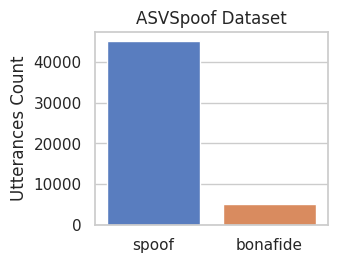

In [ ]:

categories = list(frequency_data.keys())
counts = list(frequency_data.values())

sns.set(style='whitegrid')
plt.figure(figsize=(3, 2.5))
sns.barplot(x=categories, y=counts, palette='muted')
plt.xlabel('')
plt.ylabel('Utterances Count')
plt.title('ASVSpoof Dataset')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras.layers import ConvLSTM1D
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization, Reshape
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

df = df.sample(frac = 1)
X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1),
                                                      df['label'], test_size=0.25,
                                                      random_state=101)


X_train.index = np.arange(0, len(X_train))
y_train.index = np.arange(0, len(y_train))

X_test.index = np.arange(0, len(X_test))
y_test.index = np.arange(0, len(y_test))

# oversampler= sv.distance_SMOTE()

# x_train_sampled, y_train_sampled = oversampler.sample(X_train, y_train)
# x_test_sampled, y_test_sampled = oversampler.sample(X_test, y_test)

# ada = ADASYN(random_state=130)
# X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

# scaler = StandardScaler()
# X_train_ada.iloc[:,0:]=scaler.fit_transform(X_train_ada.iloc[:,0:].to_numpy())
# X_test.iloc[:,0:]=scaler.fit_transform(X_test.iloc[:,0:].to_numpy())

In [ ]:
# X_train.index = np.arange(0, len(X_train))
# y_train.index = np.arange(0, len(y_train))

# X_test.index = np.arange(0, len(X_test))
# y_test.index = np.arange(0, len(y_test))

# oversampler= sv.distance_SMOTE()

# x_train_sampled, y_train_sampled = oversampler.sample(X_train, y_train)
# x_test_sampled, y_test_sampled = oversampler.sample(X_test, y_test)

In [ ]:
from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1, n_neighbors=3)

x_train_uns, y_train_uns = undersample.fit_resample(X_train, y_train)
x_test_uns, y_test_uns = undersample.fit_resample(X_test, y_test)

In [ ]:
y_train_uns.value_counts()

0.0    3835
1.0    3835
Name: label, dtype: int64

**SVM**

In [ ]:
y_train_uns.value_counts()

0.0    3835
1.0    3835
Name: label, dtype: int64

In [ ]:
y_test_uns.value_counts()

0.0    1293
1.0    1293
Name: label, dtype: int64

In [ ]:
from sklearn.svm import SVC
model_svm = SVC(C=0.1, gamma=0.001, kernel='poly')
model_svm.fit(x_train_uns, y_train_uns)
y_pred1 = model_svm.predict(x_test_uns)

from sklearn.metrics import accuracy_score

# printing the accuracy of the model
print(accuracy_score(y_test_uns, y_pred1))

0.9640371229698376


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_uns,y_pred1))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      1293
         1.0       0.97      0.96      0.96      1293

    accuracy                           0.96      2586
   macro avg       0.96      0.96      0.96      2586
weighted avg       0.96      0.96      0.96      2586



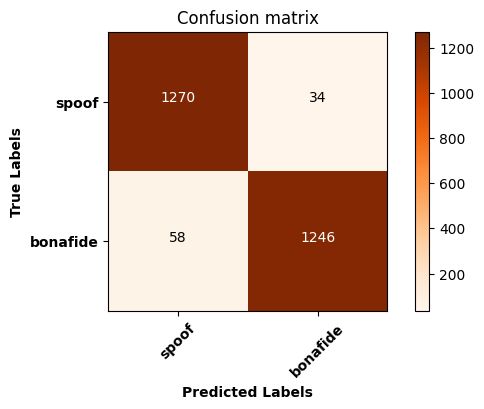

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=201,criterion = "entropy")
model_rf.fit(x_train_uns, y_train_uns)
model_rf.score(x_test_uns,y_test_uns)
y_pred2 = model_rf.predict(x_test_uns)
print(accuracy_score(y_test_uns, y_pred2))

0.9640371229698376


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_uns,y_pred2))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1293
         1.0       0.95      0.98      0.96      1293

    accuracy                           0.96      2586
   macro avg       0.96      0.96      0.96      2586
weighted avg       0.96      0.96      0.96      2586



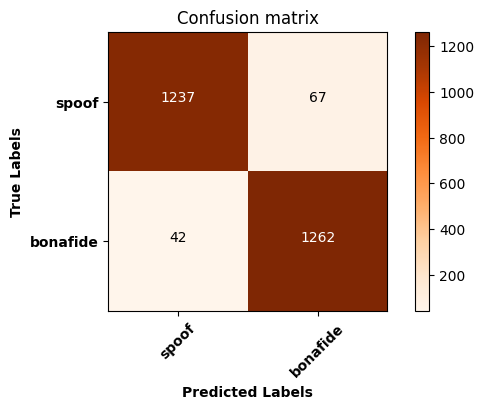

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(x_train_uns, y_train_uns)
model_knn.score(x_test_uns, y_test_uns)

0.9133797370456304

In [ ]:
y_pred3 = model_knn.predict(x_test_uns)
from sklearn.metrics import classification_report
print(classification_report(y_test_uns,y_pred3))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      1293
         1.0       0.97      0.85      0.91      1293

    accuracy                           0.91      2586
   macro avg       0.92      0.91      0.91      2586
weighted avg       0.92      0.91      0.91      2586



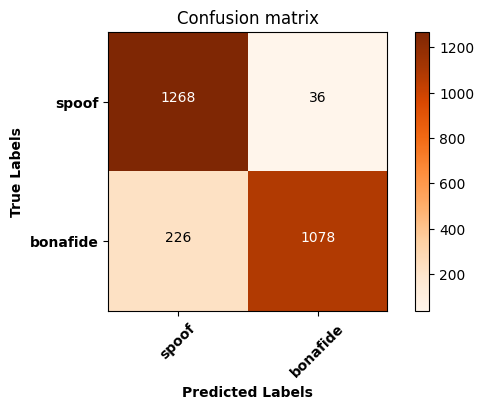

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

**XGBoost**

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

params = {
    'objective':'binary:logistic',
    'max_depth':4,
    'alpha':10,
    'learning_rate':1.0,
    'n_estimators':100
}

model_xgboost = XGBClassifier(**params)
model_xgboost.fit(x_train_uns,y_train_uns)
y_pred4 = model_xgboost.predict(x_test_uns)

print(classification_report(y_test_uns,y_pred4))

from sklearn.metrics import accuracy_score
accuracy_score(y_test_uns,y_pred4)

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1293
         1.0       0.96      0.96      0.96      1293

    accuracy                           0.96      2586
   macro avg       0.96      0.96      0.96      2586
weighted avg       0.96      0.96      0.96      2586



0.9590100541376644

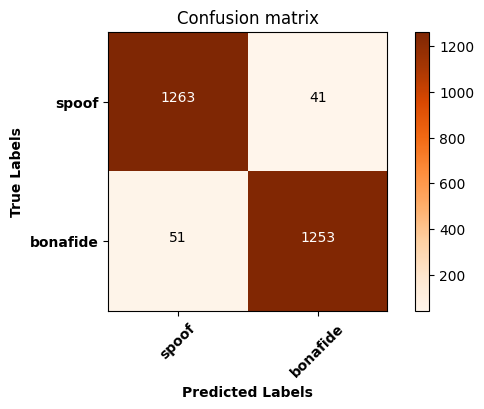

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

**MLP**

In [ ]:
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(random_state=1, max_iter=300).fit(x_train_uns, y_train_uns)
model_mlp.score(x_test_uns, y_test_uns)
y_pred5 = model_mlp.predict(x_test_uns)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_uns,y_pred5)

0.9651972157772621

In [ ]:
print(classification_report(y_test_uns,y_pred5))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      1293
         1.0       0.96      0.97      0.97      1293

    accuracy                           0.97      2586
   macro avg       0.97      0.97      0.97      2586
weighted avg       0.97      0.97      0.97      2586



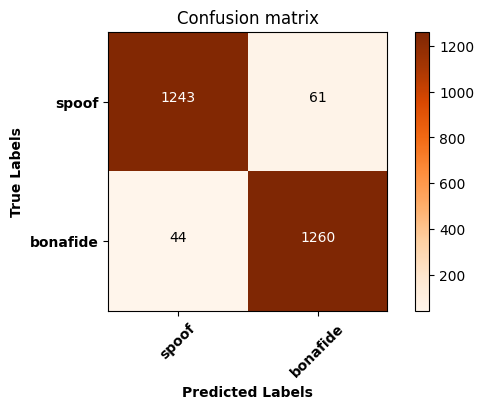

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

# Gradient Boosting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingClassifier
param={'n_estimators':(5,10,20,40,60,80,100,120,140,160,180),'learning_rate':(0.1,0.2,0.4,0.8,1.0,1.2,1.6)}

model_gradient  = GradientBoostingClassifier()
model_gradient.fit(x_train_uns,y_train_uns)
print(model_gradient.score(x_test_uns,y_test_uns))

y_pred6 = model_gradient.predict(x_test_uns)
print(classification_report(y_test_uns,y_pred6))

0.9477958236658933
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      1293
         1.0       0.95      0.95      0.95      1293

    accuracy                           0.95      2586
   macro avg       0.95      0.95      0.95      2586
weighted avg       0.95      0.95      0.95      2586



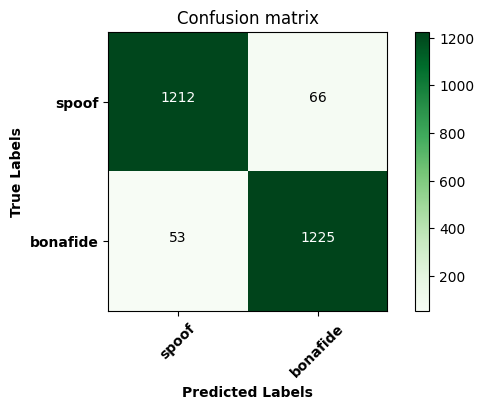

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred5)], y_pred = y_pred5, map_col = 'Greens')

# AdaBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
param={'n_estimators':(5,10,20,40,60,80,100,120,140,160,180),'learning_rate':(0.1,0.2,0.4,0.8,1.0,1.2,1.6)}

model_gradient  = AdaBoostClassifier()
model_gradient.fit(x_train_uns,y_train_uns)
print(model_gradient.score(x_test_uns,y_test_uns))

y_pred7 = model_gradient.predict(x_test_uns)
print(classification_report(y_test_uns,y_pred7))

0.9338747099767981
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1293
         1.0       0.94      0.93      0.93      1293

    accuracy                           0.93      2586
   macro avg       0.93      0.93      0.93      2586
weighted avg       0.93      0.93      0.93      2586



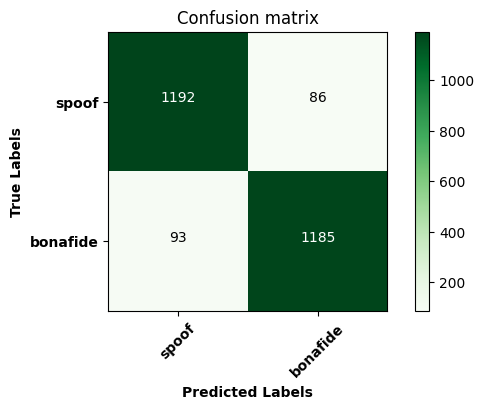

In [ ]:
classes = ["spoof", "bonafide"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test_uns[:len(y_pred5)], y_pred = y_pred5, map_col = 'Greens')

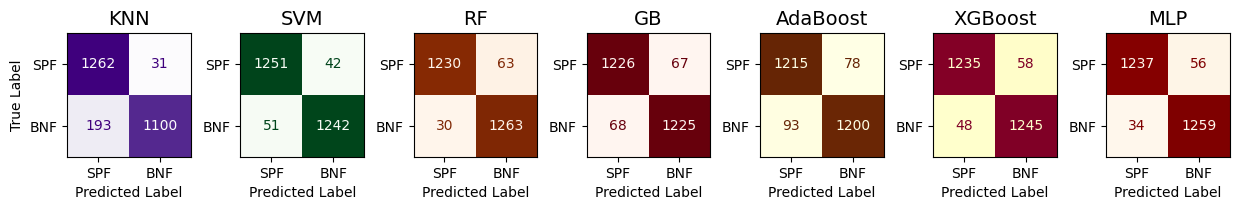

In [ ]:
f, axes = plt.subplots(1, 7)

f.set_figheight(3)
f.set_figwidth(15)

x = 0
mp_col = ['Purples', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd']


y = 0

names = ["KNN", "SVM", "RF", "GB", "AdaBoost", "XGBoost", "MLP"]
y_pred = 0

label_names = ["SPF", "BNF"]

for j in np.arange(7):

  # classes = ["healthy", "infected"]
  if j == 0:
    y_pred = y_pred3
  elif j == 1:
    y_pred = y_pred1
  elif j == 2:
    y_pred = y_pred2
  elif j == 3:
    y_pred = y_pred6
  elif j == 4:
    y_pred = y_pred7
  elif j == 5:
    y_pred = y_pred4
  else:
    y_pred = y_pred5

  name = names[j]
  disp = ConfusionMatrixDisplay.from_predictions(y_test_uns, y_pred, ax = axes[y], cmap = mp_col[y], colorbar = False, display_labels=label_names)
  disp.ax_.set_title(name, fontsize=14)

  disp.ax_.set_xlabel('Predicted Label', fontsize=10)

  if y != 0:
      disp.ax_.set_ylabel('')
  else:
      disp.ax_.set_ylabel('True Label', fontsize=10)

  y += 1

plt.subplots_adjust(wspace=0.4)

plt.show()

In [ ]:
for j in np.arange(7):
  print(j)

0
1
2
3
4
5
6


# **Deep Learning on DeepFake**

**FIT DNN Model**

<ipython-input-27-580dbcdd2cad>:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ada['label'] = y_train_ada


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 193)]             0         
                                                                 
 dense (Dense)               (None, 512)               99328     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256  

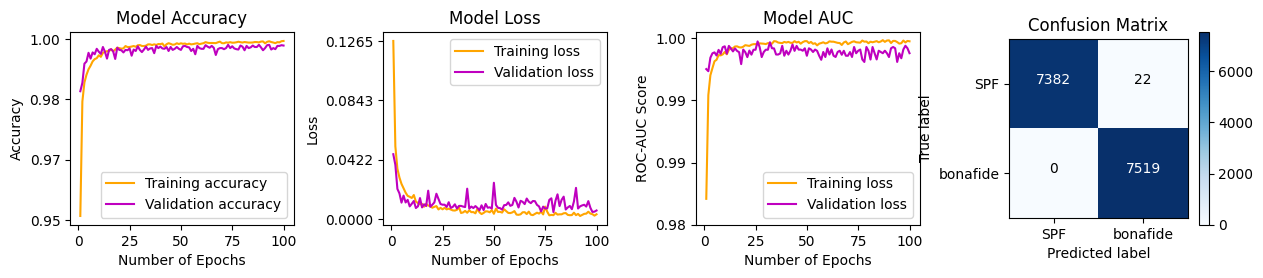

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras.layers import ConvLSTM1D
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization, Reshape
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import pickle

def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=193)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)
  hidden1 = Dense(128, activation='relu')(lay4)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(2, activation='softmax')(hidden2)
  model   = Model(inputs=inp1, outputs=output)

  return model


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=2):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 2
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size, self.n_classes), dtype=int)

    # print(self.features)
    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y


# class CustomDataset(tf.keras.utils.Sequence):
#     def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
#       self.batch_size = batch_size
#       self.dim        = target_size
#       self.labels     = labels
#       self.imgfiles   = imgfiles
#       self.n_classes  = n_classes
#       self.shuffle    = shuffle
#       self.n_channels = n_channels
#       self.scale      = scale

#       self.c          = 0
#       self.on_epoch_end()

#     def __len__(self):
#       # returns the number of batches
#       return int(np.floor(len(self.imgfiles) / self.batch_size))

#     def __getitem__(self, index):
#       # returns one batch
#       indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#       # Generate data
#       X, y = self.__data_generation(indexes)
#       return X, y

#     def on_epoch_end(self):
#       self.indexes = np.arange(len(self.imgfiles))
#       if self.shuffle == True:
#         np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#       X = np.empty((self.batch_size, *self.dim, self.n_channels))
#       y = np.empty((self.batch_size), dtype=int)

#       # Generate data
#       for i, ID in enumerate(list_IDs_temp):
#           # Store sample
#           img   = cv2.imread(self.imgfiles[ID])
#           img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#           X[i,] = img / self.scale

#           # Store class
#           y[i] = self.labels[ID]

#           self.c +=1
#       return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

class InputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X, Y, batch_size,target_size=(128,128)):
      self.genX = CustomPipeline(X, Y, batch_size=batch_size,shuffle=False)

  def __len__(self):
      return self.genX.__len__()

  def __getitem__(self, index):
      X_batch, Y_batch = self.genX.__getitem__(index)
      return X_batch, Y_batch

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1),
                                                      df['label'], test_size=0.001,
                                                      random_state=101)

ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

X_train_ada['label'] = y_train_ada
X_train_ada = X_train_ada.sample(frac=1)

y_train_ada = X_train_ada['label']
X_train_ada = X_train_ada.drop('label',axis=1)

scaler = StandardScaler()
X_train_ada.iloc[:,0:]=scaler.fit_transform(X_train_ada.iloc[:,0:].to_numpy())

X_tr = X_train_ada.iloc[:65000]
y_tr = y_train_ada.iloc[:65000]

X_val = X_train_ada.iloc[65000:75000]
y_val = y_train_ada.iloc[65000:75000]

X_test = X_train_ada.iloc[75000:]
y_test = y_train_ada.iloc[75000:]

X_tr = X_tr.values
y_tr = y_tr.values
y_tr = to_categorical(y_tr, num_classes=2)

X_val = X_val.values
y_val = y_val.values
y_val = to_categorical(y_val, num_classes=2)

X_test = X_test.values
y_test = y_test.values
y_test = to_categorical(y_test, num_classes=2)

# mfccs = X_tr.iloc[:, :40]
# chroma = X_tr.iloc[:, 40:52]
# mel = X_tr.iloc[:, 52:180]
# contrast = X_tr.iloc[:, 180:187]
# tonnetz = X_tr.iloc[:, 187:193]

# mfccs_arr = mfccs.values
# chroma_arr = chroma.values
# mel_arr = mel.values
# contrast_arr = contrast.values
# tonnetz_arr = tonnetz.values
# y_tr = y_tr.values

# mfccs_val = X_val.iloc[:, :40]
# chroma_val = X_val.iloc[:, 40:52]
# mel_val = X_val.iloc[:, 52:180]
# contrast_val = X_val.iloc[:, 180:187]
# tonnetz_val = X_val.iloc[:, 187:193]

# mfccs_val = mfccs_val.values
# chroma_val = chroma_val.values
# mel_val = mel_val.values
# contrast_val = contrast_val.values
# tonnetz_val = tonnetz_val.values
# y_val = y_val.values

# mfccs_test = X_test.iloc[:, :40]
# chroma_test = X_test.iloc[:, 40:52]
# mel_test = X_test.iloc[:, 52:180]
# contrast_test = X_test.iloc[:, 180:187]
# tonnetz_test = X_test.iloc[:, 187:193]

# mfccs_test = mfccs_test.values
# chroma_test = chroma_test.values
# mel_test = mel_test.values
# contrast_test = contrast_test.values
# tonnetz_test = tonnetz_test.values
# y_test = y_test.values

train_data = InputGenerator(X_tr, y_tr, batch_size=48)
val_data = InputGenerator(X_val, y_val, batch_size=48)
test_data = InputGenerator(X_test, y_test, batch_size=48)

class Evaluation(keras.callbacks.Callback):

  def __init__(self, data_gen, labels, val_data_gen, val_labels, test_data_gen, test_labels, model):
    super(Callback, self).__init__()
    self.train_data = data_gen
    self.train_labels = labels
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels
    self.model = model

  def on_epoch_end(self, epoch, logs=None):

    test_res = self.model.evaluate(self.test_data)
    print("Test Loss:- " + str(test_res[0]) + " Test Accuracy:- " + str(test_res[1]))

model = build_model()
print(model.summary())

evaluator = Evaluation(train_data, y_tr, val_data, y_val, test_data, y_test, model)
# checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/model/', monitor='val_loss', save_best_only=True, save_weights_only=True)
# Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=4, min_delta=0.001)

model.compile(
        optimizer = 'Adam',
        loss = 'BinaryCrossentropy',
        metrics=['Accuracy','AUC','Precision','Recall'])

history = model.fit(train_data, epochs=100, validation_data = val_data,
                      verbose = 2)
file_path = "/content/drive/MyDrive/DeepFake/FIT_DNN.h5"
model.save(file_path)
test_res  = model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

print("Test Loss :-", test_res[0])
print("Test Precision :-",precision_score(y_true[:len(y_pred)], y_pred))
print("Test Recall :-",recall_score(y_true[:len(y_pred)], y_pred))
print("Test Accuracy :-",test_res[1])
print("Test AUC :-",test_res[2])

print("*******************************")


# y_test_pred = model.predict(test_data)
# print("AUC Score:- ", roc_auc_score(y_test[:len(y_test_pred)],y_test_pred))
print("\n")

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

import matplotlib.pyplot as plt

def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["SPF", "bonafide"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")


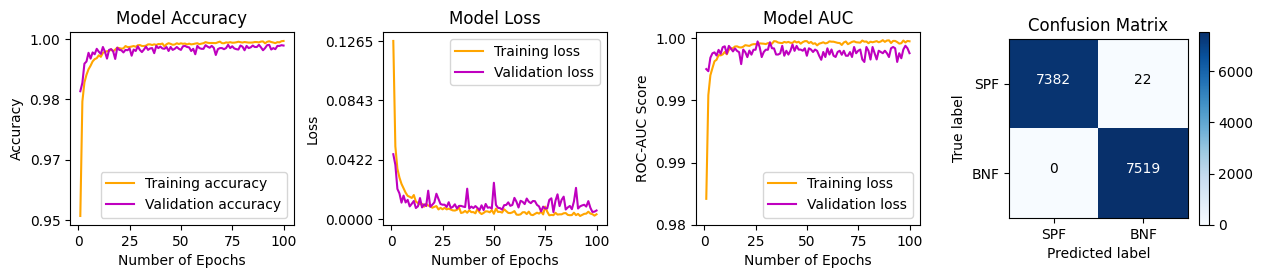

In [ ]:
def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["SPF", "BNF"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")


**DNN CNN Model**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras.layers import ConvLSTM1D
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization, Reshape
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import pickle

def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=193)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay61  = Reshape((64,8,1))(lay2)
  lay62  = Conv2D(32, (3, 3), strides=(2, 2))(lay61)
  lay63  = AveragePooling2D((2, 2), strides=(2,2))(lay62)
  lay64  = BatchNormalization()(lay63)
  lay65  = Activation('relu')(lay64)

  lay66  = Conv2D(64, (3, 3), padding="same") (lay65)
  # lay67  = AveragePooling2D((2, 2), strides=(2,2)) (lay66)
  lay68  = BatchNormalization()(lay66)
  lay69  = Activation('relu')(lay68)

  lay611  = Conv2D(64, (3, 3), padding="same") (lay69)
  # lay612 = AveragePooling2D((2, 2), strides=(2,2)) (lay611)
  lay613 = BatchNormalization()(lay611)
  lay614 = Activation('relu')(lay613)

  lay615 = Flatten()(lay614)
  lay616 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay615)
  lay617 = Dropout(rate=0.5)(lay616)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)
  hidden1 = Dense(128, activation='relu')(lay4)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(2, activation='softmax')(hidden2)
  model   = Model(inputs=inp1, outputs=output)

  return model


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=2):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 2
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size, self.n_classes), dtype=int)

    # print(self.features)
    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y


# class CustomDataset(tf.keras.utils.Sequence):
#     def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
#       self.batch_size = batch_size
#       self.dim        = target_size
#       self.labels     = labels
#       self.imgfiles   = imgfiles
#       self.n_classes  = n_classes
#       self.shuffle    = shuffle
#       self.n_channels = n_channels
#       self.scale      = scale

#       self.c          = 0
#       self.on_epoch_end()

#     def __len__(self):
#       # returns the number of batches
#       return int(np.floor(len(self.imgfiles) / self.batch_size))

#     def __getitem__(self, index):
#       # returns one batch
#       indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#       # Generate data
#       X, y = self.__data_generation(indexes)
#       return X, y

#     def on_epoch_end(self):
#       self.indexes = np.arange(len(self.imgfiles))
#       if self.shuffle == True:
#         np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#       X = np.empty((self.batch_size, *self.dim, self.n_channels))
#       y = np.empty((self.batch_size), dtype=int)

#       # Generate data
#       for i, ID in enumerate(list_IDs_temp):
#           # Store sample
#           img   = cv2.imread(self.imgfiles[ID])
#           img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#           X[i,] = img / self.scale

#           # Store class
#           y[i] = self.labels[ID]

#           self.c +=1
#       return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

class InputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X, Y, batch_size,target_size=(128,128)):
      self.genX = CustomPipeline(X, Y, batch_size=batch_size,shuffle=False)

  def __len__(self):
      return self.genX.__len__()

  def __getitem__(self, index):
      X_batch, Y_batch = self.genX.__getitem__(index)
      return X_batch, Y_batch

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1),
                                                      df['label'], test_size=0.001,
                                                      random_state=101)

ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

X_train_ada['label'] = y_train_ada
X_train_ada = X_train_ada.sample(frac=1)

y_train_ada = X_train_ada['label']
X_train_ada = X_train_ada.drop('label',axis=1)

scaler = StandardScaler()
X_train_ada.iloc[:,0:]=scaler.fit_transform(X_train_ada.iloc[:,0:].to_numpy())

X_tr = X_train_ada.iloc[:65000]
y_tr = y_train_ada.iloc[:65000]

X_val = X_train_ada.iloc[65000:75000]
y_val = y_train_ada.iloc[65000:75000]

X_test = X_train_ada.iloc[75000:]
y_test = y_train_ada.iloc[75000:]

X_tr = X_tr.values
y_tr = y_tr.values
y_tr = to_categorical(y_tr, num_classes=2)

X_val = X_val.values
y_val = y_val.values
y_val = to_categorical(y_val, num_classes=2)

X_test = X_test.values
y_test = y_test.values
y_test = to_categorical(y_test, num_classes=2)

# mfccs = X_tr.iloc[:, :40]
# chroma = X_tr.iloc[:, 40:52]
# mel = X_tr.iloc[:, 52:180]
# contrast = X_tr.iloc[:, 180:187]
# tonnetz = X_tr.iloc[:, 187:193]

# mfccs_arr = mfccs.values
# chroma_arr = chroma.values
# mel_arr = mel.values
# contrast_arr = contrast.values
# tonnetz_arr = tonnetz.values
# y_tr = y_tr.values

# mfccs_val = X_val.iloc[:, :40]
# chroma_val = X_val.iloc[:, 40:52]
# mel_val = X_val.iloc[:, 52:180]
# contrast_val = X_val.iloc[:, 180:187]
# tonnetz_val = X_val.iloc[:, 187:193]

# mfccs_val = mfccs_val.values
# chroma_val = chroma_val.values
# mel_val = mel_val.values
# contrast_val = contrast_val.values
# tonnetz_val = tonnetz_val.values
# y_val = y_val.values

# mfccs_test = X_test.iloc[:, :40]
# chroma_test = X_test.iloc[:, 40:52]
# mel_test = X_test.iloc[:, 52:180]
# contrast_test = X_test.iloc[:, 180:187]
# tonnetz_test = X_test.iloc[:, 187:193]

# mfccs_test = mfccs_test.values
# chroma_test = chroma_test.values
# mel_test = mel_test.values
# contrast_test = contrast_test.values
# tonnetz_test = tonnetz_test.values
# y_test = y_test.values

train_data = InputGenerator(X_tr, y_tr, batch_size=48)
val_data = InputGenerator(X_val, y_val, batch_size=48)
test_data = InputGenerator(X_test, y_test, batch_size=48)

class Evaluation(keras.callbacks.Callback):

  def __init__(self, data_gen, labels, val_data_gen, val_labels, test_data_gen, test_labels, model):
    super(Callback, self).__init__()
    self.train_data = data_gen
    self.train_labels = labels
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels
    self.model = model

  def on_epoch_end(self, epoch, logs=None):

    test_res = self.model.evaluate(self.test_data)
    print("Test Loss:- " + str(test_res[0]) + " Test Accuracy:- " + str(test_res[1]))

model = build_model()
print(model.summary())

evaluator = Evaluation(train_data, y_tr, val_data, y_val, test_data, y_test, model)
# checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/model/', monitor='val_loss', save_best_only=True, save_weights_only=True)
# Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=4, min_delta=0.001)

model.compile(
        optimizer = 'Adam',
        loss = 'BinaryCrossentropy',
        metrics=['Accuracy','AUC','Precision','Recall'])

history = model.fit(train_data, epochs=100, validation_data = val_data,
                      verbose = 2)

test_res  = model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

print("Test Loss :-", test_res[0])
print("Test Precision :-",precision_score(y_true[:len(y_pred)], y_pred))
print("Test Recall :-",recall_score(y_true[:len(y_pred)], y_pred))
print("Test Accuracy :-",test_res[1])
print("Test AUC :-",test_res[2])

print("*******************************")


# y_test_pred = model.predict(test_data)
# print("AUC Score:- ", roc_auc_score(y_test[:len(y_test_pred)],y_test_pred))
print("\n")

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

import matplotlib.pyplot as plt

def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["SPF", "BNF"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")


<ipython-input-5-d251a72c1751>:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ada['label'] = y_train_ada


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 193)]             0         
                                                                 
 dense (Dense)               (None, 512)               99328     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256  

NameError: ignored

310/310 [==============================] - 1s 3ms/step
Test Loss :- 0.08279864490032196
Test Precision :- 0.9922563417890521
Test Recall :- 1.0
Test Accuracy :- 0.9961021542549133
Test AUC :- 0.9973676204681396
*******************************


467/467 [==============================] - 2s 4ms/step


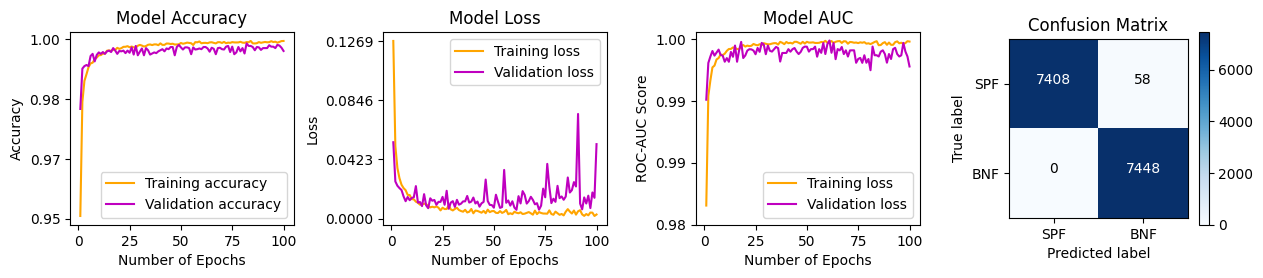

In [ ]:
import itertools
test_res  = model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

print("Test Loss :-", test_res[0])
print("Test Precision :-",precision_score(y_true[:len(y_pred)], y_pred))
print("Test Recall :-",recall_score(y_true[:len(y_pred)], y_pred))
print("Test Accuracy :-",test_res[1])
print("Test AUC :-",test_res[2])

print("*******************************")


# y_test_pred = model.predict(test_data)
# print("AUC Score:- ", roc_auc_score(y_test[:len(y_test_pred)],y_test_pred))
print("\n")

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

import matplotlib.pyplot as plt

def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["SPF", "BNF"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")


**DNN ConvLSTM Model**

<ipython-input-8-cc7235e5bfe8>:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ada['label'] = y_train_ada


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 193)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               99328     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256

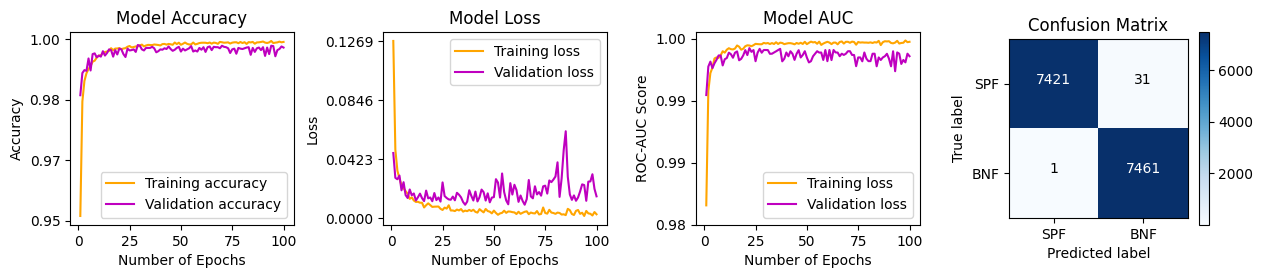

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras.layers import ConvLSTM1D
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization, Reshape
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import pickle

def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=193)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay61  = Reshape((64,8,1))(lay2)
  lay62  = ConvLSTM1D(filters=40, kernel_size=(3),
                  padding='same',input_shape=(None, 64, 8, 1),return_sequences=True)(lay61)
  lay63  = BatchNormalization()(lay62)
  lay64  = ConvLSTM1D(filters=40, kernel_size=(3),
                  padding='same', return_sequences=True)(lay63)
  lay614 = BatchNormalization()(lay64)
  lay615 = Flatten()(lay614)
  lay616 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay615)
  lay617 = Dropout(rate=0.5)(lay616)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)
  hidden1 = Dense(128, activation='relu')(lay4)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(2, activation='softmax')(hidden2)
  model   = Model(inputs=inp1, outputs=output)

  return model


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=2):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 2
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size, self.n_classes), dtype=int)

    # print(self.features)
    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y


# class CustomDataset(tf.keras.utils.Sequence):
#     def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
#       self.batch_size = batch_size
#       self.dim        = target_size
#       self.labels     = labels
#       self.imgfiles   = imgfiles
#       self.n_classes  = n_classes
#       self.shuffle    = shuffle
#       self.n_channels = n_channels
#       self.scale      = scale

#       self.c          = 0
#       self.on_epoch_end()

#     def __len__(self):
#       # returns the number of batches
#       return int(np.floor(len(self.imgfiles) / self.batch_size))

#     def __getitem__(self, index):
#       # returns one batch
#       indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#       # Generate data
#       X, y = self.__data_generation(indexes)
#       return X, y

#     def on_epoch_end(self):
#       self.indexes = np.arange(len(self.imgfiles))
#       if self.shuffle == True:
#         np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#       X = np.empty((self.batch_size, *self.dim, self.n_channels))
#       y = np.empty((self.batch_size), dtype=int)

#       # Generate data
#       for i, ID in enumerate(list_IDs_temp):
#           # Store sample
#           img   = cv2.imread(self.imgfiles[ID])
#           img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#           X[i,] = img / self.scale

#           # Store class
#           y[i] = self.labels[ID]

#           self.c +=1
#       return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

class InputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X, Y, batch_size,target_size=(128,128)):
      self.genX = CustomPipeline(X, Y, batch_size=batch_size,shuffle=False)

  def __len__(self):
      return self.genX.__len__()

  def __getitem__(self, index):
      X_batch, Y_batch = self.genX.__getitem__(index)
      return X_batch, Y_batch

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1),
                                                      df['label'], test_size=0.001,
                                                      random_state=101)

ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

X_train_ada['label'] = y_train_ada
X_train_ada = X_train_ada.sample(frac=1)

y_train_ada = X_train_ada['label']
X_train_ada = X_train_ada.drop('label',axis=1)

scaler = StandardScaler()
X_train_ada.iloc[:,0:]=scaler.fit_transform(X_train_ada.iloc[:,0:].to_numpy())

X_tr = X_train_ada.iloc[:65000]
y_tr = y_train_ada.iloc[:65000]

X_val = X_train_ada.iloc[65000:75000]
y_val = y_train_ada.iloc[65000:75000]

X_test = X_train_ada.iloc[75000:]
y_test = y_train_ada.iloc[75000:]

X_tr = X_tr.values
y_tr = y_tr.values
y_tr = to_categorical(y_tr, num_classes=2)

X_val = X_val.values
y_val = y_val.values
y_val = to_categorical(y_val, num_classes=2)

X_test = X_test.values
y_test = y_test.values
y_test = to_categorical(y_test, num_classes=2)

# mfccs = X_tr.iloc[:, :40]
# chroma = X_tr.iloc[:, 40:52]
# mel = X_tr.iloc[:, 52:180]
# contrast = X_tr.iloc[:, 180:187]
# tonnetz = X_tr.iloc[:, 187:193]

# mfccs_arr = mfccs.values
# chroma_arr = chroma.values
# mel_arr = mel.values
# contrast_arr = contrast.values
# tonnetz_arr = tonnetz.values
# y_tr = y_tr.values

# mfccs_val = X_val.iloc[:, :40]
# chroma_val = X_val.iloc[:, 40:52]
# mel_val = X_val.iloc[:, 52:180]
# contrast_val = X_val.iloc[:, 180:187]
# tonnetz_val = X_val.iloc[:, 187:193]

# mfccs_val = mfccs_val.values
# chroma_val = chroma_val.values
# mel_val = mel_val.values
# contrast_val = contrast_val.values
# tonnetz_val = tonnetz_val.values
# y_val = y_val.values

# mfccs_test = X_test.iloc[:, :40]
# chroma_test = X_test.iloc[:, 40:52]
# mel_test = X_test.iloc[:, 52:180]
# contrast_test = X_test.iloc[:, 180:187]
# tonnetz_test = X_test.iloc[:, 187:193]

# mfccs_test = mfccs_test.values
# chroma_test = chroma_test.values
# mel_test = mel_test.values
# contrast_test = contrast_test.values
# tonnetz_test = tonnetz_test.values
# y_test = y_test.values

train_data = InputGenerator(X_tr, y_tr, batch_size=48)
val_data = InputGenerator(X_val, y_val, batch_size=48)
test_data = InputGenerator(X_test, y_test, batch_size=48)

class Evaluation(keras.callbacks.Callback):

  def __init__(self, data_gen, labels, val_data_gen, val_labels, test_data_gen, test_labels, model):
    super(Callback, self).__init__()
    self.train_data = data_gen
    self.train_labels = labels
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels
    self.model = model

  def on_epoch_end(self, epoch, logs=None):

    test_res = self.model.evaluate(self.test_data)
    print("Test Loss:- " + str(test_res[0]) + " Test Accuracy:- " + str(test_res[1]))

model = build_model()
print(model.summary())

evaluator = Evaluation(train_data, y_tr, val_data, y_val, test_data, y_test, model)
# checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/model/', monitor='val_loss', save_best_only=True, save_weights_only=True)
# Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=4, min_delta=0.001)

model.compile(
        optimizer = 'Adam',
        loss = 'BinaryCrossentropy',
        metrics=['Accuracy','AUC','Precision','Recall'])

history = model.fit(train_data, epochs=100, validation_data = val_data,
                      verbose = 2)

test_res  = model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

print("Test Loss :-", test_res[0])
print("Test Precision :-",precision_score(y_true[:len(y_pred)], y_pred))
print("Test Recall :-",recall_score(y_true[:len(y_pred)], y_pred))
print("Test Accuracy :-",test_res[1])
print("Test AUC :-",test_res[2])

print("*******************************")


# y_test_pred = model.predict(test_data)
# print("AUC Score:- ", roc_auc_score(y_test[:len(y_test_pred)],y_test_pred))
print("\n")

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

import matplotlib.pyplot as plt

def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["SPF", "BNF"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")


**DNN BiLsTM**

<ipython-input-9-bd08db912e3f>:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ada['label'] = y_train_ada


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 193)]             0         
                                                                 
 dense_12 (Dense)            (None, 512)               99328     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 reshape_2 (Reshape)         (None, 64, 8)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 64, 8)            32        
 hNormalization)                                                 
                                                                 
 bidirectional (Bidirectiona  (None, 64, 128)          37376     
 l)                                                        

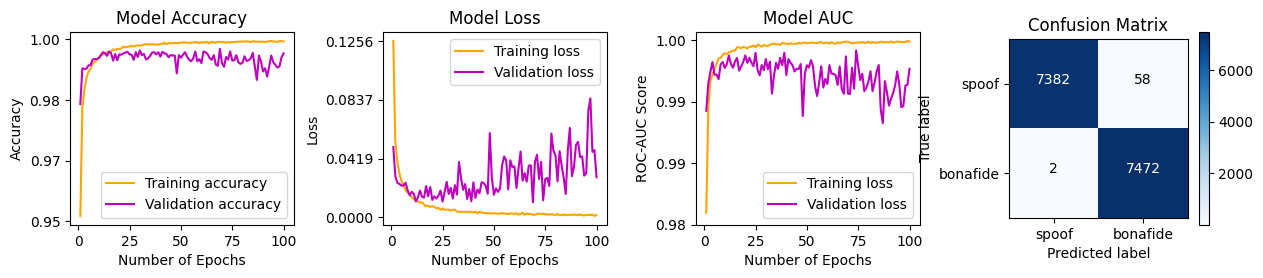

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras.layers import Bidirectional, LSTM
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization, Reshape
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import pickle

def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=193)
  lay1   = Dense(units=512, activation='relu', kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay2   = Reshape((64, 8))(lay2)
  lay2   = BatchNormalization()(lay2)
  lay2   = Bidirectional(LSTM(64, return_sequences=True))(lay2)
  lay2   = Bidirectional(LSTM(64))(lay2)
  lay3   = Dense(units=256, activation='relu', kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)
  hidden1 = Dense(128, activation='relu')(lay4)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(2, activation='softmax')(hidden2)
  model   = Model(inputs=inp1, outputs=output)

  return model


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=2):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 2
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size, self.n_classes), dtype=int)

    # print(self.features)
    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y


# class CustomDataset(tf.keras.utils.Sequence):
#     def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
#       self.batch_size = batch_size
#       self.dim        = target_size
#       self.labels     = labels
#       self.imgfiles   = imgfiles
#       self.n_classes  = n_classes
#       self.shuffle    = shuffle
#       self.n_channels = n_channels
#       self.scale      = scale

#       self.c          = 0
#       self.on_epoch_end()

#     def __len__(self):
#       # returns the number of batches
#       return int(np.floor(len(self.imgfiles) / self.batch_size))

#     def __getitem__(self, index):
#       # returns one batch
#       indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#       # Generate data
#       X, y = self.__data_generation(indexes)
#       return X, y

#     def on_epoch_end(self):
#       self.indexes = np.arange(len(self.imgfiles))
#       if self.shuffle == True:
#         np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#       X = np.empty((self.batch_size, *self.dim, self.n_channels))
#       y = np.empty((self.batch_size), dtype=int)

#       # Generate data
#       for i, ID in enumerate(list_IDs_temp):
#           # Store sample
#           img   = cv2.imread(self.imgfiles[ID])
#           img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#           X[i,] = img / self.scale

#           # Store class
#           y[i] = self.labels[ID]

#           self.c +=1
#       return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

class InputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X, Y, batch_size,target_size=(128,128)):
      self.genX = CustomPipeline(X, Y, batch_size=batch_size,shuffle=False)

  def __len__(self):
      return self.genX.__len__()

  def __getitem__(self, index):
      X_batch, Y_batch = self.genX.__getitem__(index)
      return X_batch, Y_batch

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1),
                                                      df['label'], test_size=0.001,
                                                      random_state=101)

ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

X_train_ada['label'] = y_train_ada
X_train_ada = X_train_ada.sample(frac=1)

y_train_ada = X_train_ada['label']
X_train_ada = X_train_ada.drop('label',axis=1)

scaler = StandardScaler()
X_train_ada.iloc[:,0:]=scaler.fit_transform(X_train_ada.iloc[:,0:].to_numpy())

X_tr = X_train_ada.iloc[:65000]
y_tr = y_train_ada.iloc[:65000]

X_val = X_train_ada.iloc[65000:75000]
y_val = y_train_ada.iloc[65000:75000]

X_test = X_train_ada.iloc[75000:]
y_test = y_train_ada.iloc[75000:]

X_tr = X_tr.values
y_tr = y_tr.values
y_tr = to_categorical(y_tr, num_classes=2)

X_val = X_val.values
y_val = y_val.values
y_val = to_categorical(y_val, num_classes=2)

X_test = X_test.values
y_test = y_test.values
y_test = to_categorical(y_test, num_classes=2)

# mfccs = X_tr.iloc[:, :40]
# chroma = X_tr.iloc[:, 40:52]
# mel = X_tr.iloc[:, 52:180]
# contrast = X_tr.iloc[:, 180:187]
# tonnetz = X_tr.iloc[:, 187:193]

# mfccs_arr = mfccs.values
# chroma_arr = chroma.values
# mel_arr = mel.values
# contrast_arr = contrast.values
# tonnetz_arr = tonnetz.values
# y_tr = y_tr.values

# mfccs_val = X_val.iloc[:, :40]
# chroma_val = X_val.iloc[:, 40:52]
# mel_val = X_val.iloc[:, 52:180]
# contrast_val = X_val.iloc[:, 180:187]
# tonnetz_val = X_val.iloc[:, 187:193]

# mfccs_val = mfccs_val.values
# chroma_val = chroma_val.values
# mel_val = mel_val.values
# contrast_val = contrast_val.values
# tonnetz_val = tonnetz_val.values
# y_val = y_val.values

# mfccs_test = X_test.iloc[:, :40]
# chroma_test = X_test.iloc[:, 40:52]
# mel_test = X_test.iloc[:, 52:180]
# contrast_test = X_test.iloc[:, 180:187]
# tonnetz_test = X_test.iloc[:, 187:193]

# mfccs_test = mfccs_test.values
# chroma_test = chroma_test.values
# mel_test = mel_test.values
# contrast_test = contrast_test.values
# tonnetz_test = tonnetz_test.values
# y_test = y_test.values

train_data = InputGenerator(X_tr, y_tr, batch_size=48)
val_data = InputGenerator(X_val, y_val, batch_size=48)
test_data = InputGenerator(X_test, y_test, batch_size=48)

class Evaluation(keras.callbacks.Callback):

  def __init__(self, data_gen, labels, val_data_gen, val_labels, test_data_gen, test_labels, model):
    super(Callback, self).__init__()
    self.train_data = data_gen
    self.train_labels = labels
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels
    self.model = model

  def on_epoch_end(self, epoch, logs=None):

    test_res = self.model.evaluate(self.test_data)
    print("Test Loss:- " + str(test_res[0]) + " Test Accuracy:- " + str(test_res[1]))

model = build_model()
print(model.summary())

evaluator = Evaluation(train_data, y_tr, val_data, y_val, test_data, y_test, model)
# checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/model/', monitor='val_loss', save_best_only=True, save_weights_only=True)
# Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=4, min_delta=0.001)

model.compile(
        optimizer = 'Adam',
        loss = 'BinaryCrossentropy',
        metrics=['Accuracy','AUC','Precision','Recall'])

history = model.fit(train_data, epochs=100, validation_data = val_data,
                      verbose = 2)

file_path = "/content/drive/MyDrive/DeepFake/DNN_BiLSTM.h5"
model.save(file_path)

test_res  = model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

print("Test Loss :-", test_res[0])
print("Test Precision :-",precision_score(y_true[:len(y_pred)], y_pred))
print("Test Recall :-",recall_score(y_true[:len(y_pred)], y_pred))
print("Test Accuracy :-",test_res[1])
print("Test AUC :-",test_res[2])

print("*******************************")


# y_test_pred = model.predict(test_data)
# print("AUC Score:- ", roc_auc_score(y_test[:len(y_test_pred)],y_test_pred))
print("\n")

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = np.array(list(map(lambda x: np.argmax(x), y_test)))

import matplotlib.pyplot as plt

def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["spoof", "bonafide"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")


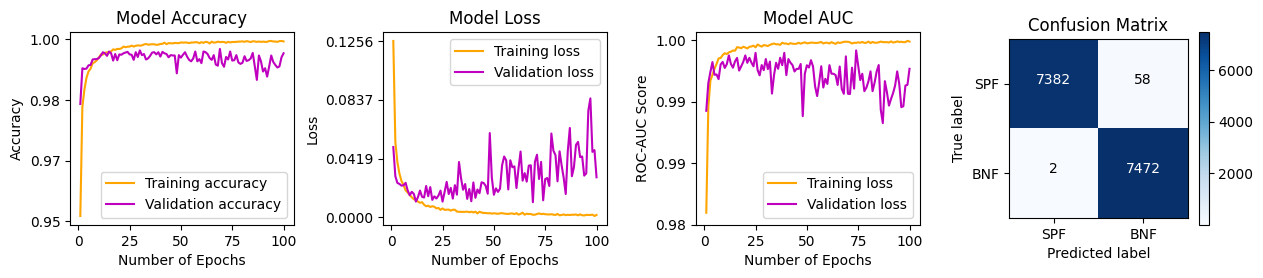

In [ ]:
def plot_training_history_confusion_matrix(history, y_true, y_pred):
    # Retrieve the accuracy and loss values from the history dictionary
    train_acc = history['Accuracy']
    val_acc = history['val_Accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_auc = history['auc']
    val_auc = history['val_auc']

    # Retrieve the number of epochs
    epochs = range(1, len(train_acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2.5))

    # Plot training and validation accuracy
    ax1.plot(epochs, train_acc, 'orange', label='Training accuracy')
    ax1.plot(epochs, val_acc, 'm', label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_yticks(np.linspace(0.95, 1, 4))
    ax1.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.95, 1, 4)])
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, train_loss, 'orange', label='Training loss')
    ax2.plot(epochs, val_loss, 'm', label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_yticks(np.linspace(0, max(max(train_loss), max(val_loss)), 4))
    ax2.legend()

    ax3.plot(epochs, train_auc, 'orange', label='Training loss')
    ax3.plot(epochs, val_auc, 'm', label='Validation loss')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Number of Epochs')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_yticks(np.linspace(0.985, 1, 4))
    ax3.set_yticklabels(['{:.2f}'.format(tick) for tick in np.linspace(0.985, 1, 4)])
    ax3.legend()

    cm = confusion_matrix(y_true, y_pred)
    classes = ["SPF", "BNF"]
    ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax4.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    ax4.set_xticks(tick_marks)
    ax4.set_xticklabels(classes)
    ax4.set_yticks(tick_marks)
    ax4.set_yticklabels(classes)
    ax4.set_ylabel('True label')
    ax4.set_xlabel('Predicted label')
    plt.colorbar(ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

    # Label each cell with the count
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax4.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

plot_training_history_confusion_matrix(history.history, y_true[:len(y_pred)], y_pred)

print("\n")